---------------------------------------
# Wczytanie zestawu danych historycznego zapotrzebowania (PSE)
---------------------------------------

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df_load = pd.read_csv('data/power_system_load_all.csv')
df_load['date'] = pd.to_datetime(df_load['date'], format='%d.%m.%Y %H:%M')

# Przykładowy wycinek zestawu danych

In [2]:
df_load.head()

,date,electricity_load,forecasted_load
0,2015-01-02 01:00:00,13720.800,13828.0
1,2015-01-02 02:00:00,13258.475,13212.0
2,2015-01-02 03:00:00,13010.575,13028.0
3,2015-01-02 04:00:00,13006.900,13056.0
4,2015-01-02 05:00:00,13241.450,13426.0


# Wizualizacja przykładowych rekordów dla ostatnich 24 godzin

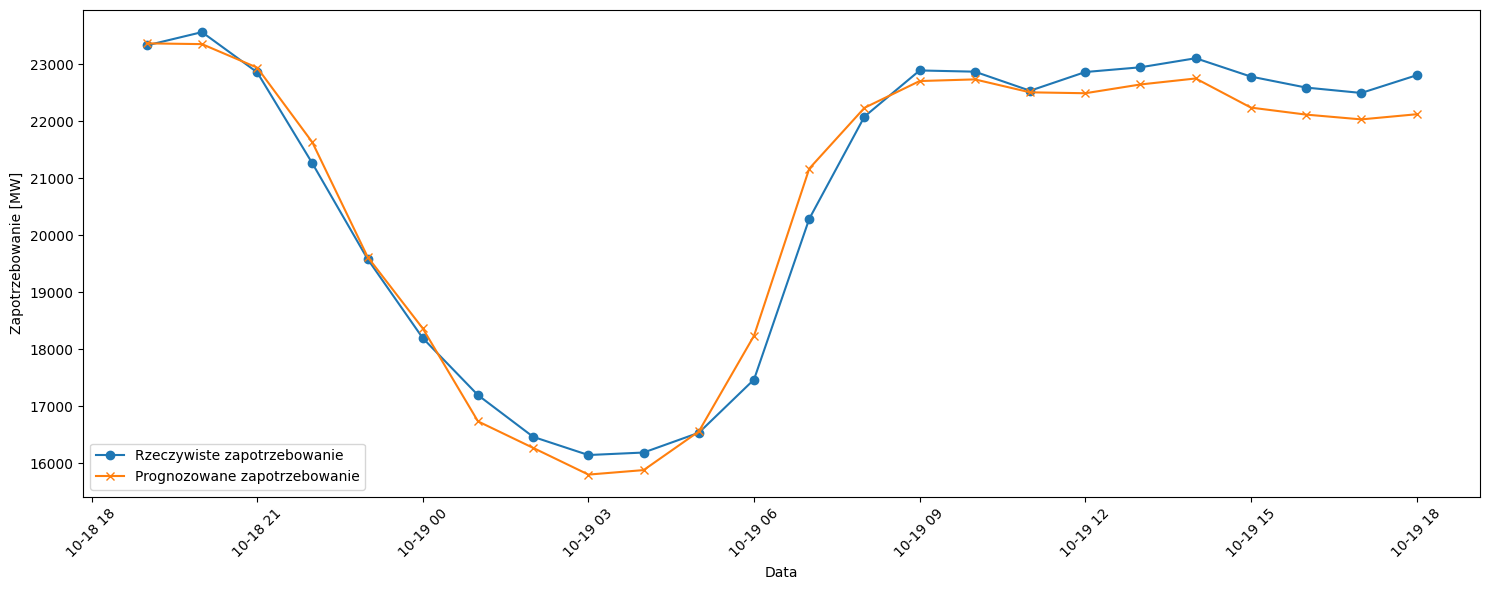

In [3]:
df_last_24 = df_load.tail(24)
df_last_24.set_index('date', inplace=True)
plt.figure(figsize=(15, 6))
plt.plot(df_last_24.index, df_last_24['electricity_load'], label='Rzeczywiste zapotrzebowanie', marker='o')
plt.plot(df_last_24.index, df_last_24['forecasted_load'], label='Prognozowane zapotrzebowanie', marker='x')
plt.xlabel('Data')
plt.ylabel('Zapotrzebowanie [MW]')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---------------------------------------
# Analiza i przetwarzanie zestawu danych historycznego zapotrzebowania
---------------------------------------

# Sprawdzenie brakujących rekordów

In [4]:
df_load.isna().sum()

date                 0
electricity_load    33
forecasted_load     48
dtype: int64

# Interpolacja brakujących rekordów

In [5]:
df_load['electricity_load'] = df_load['electricity_load'].interpolate(method='polynomial', order=3)
df_load['forecasted_load'] = df_load['forecasted_load'].interpolate(method='polynomial', order=3)

# Rozkład danych

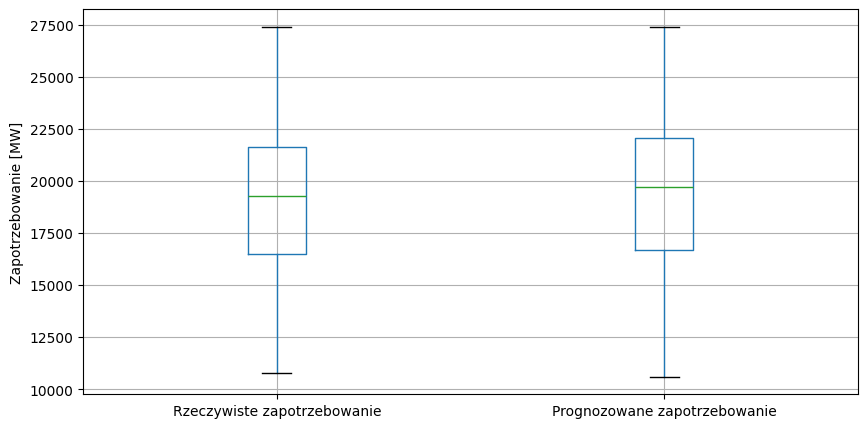

In [6]:
import matplotlib.pyplot as plt

temp_df = df_load[['electricity_load', 'forecasted_load']].rename(columns={'electricity_load': 'Rzeczywiste zapotrzebowanie', 'forecasted_load': 'Prognozowane zapotrzebowanie'})
plt.figure(figsize=(10, 5))
temp_df.boxplot()
plt.ylabel('Zapotrzebowanie [MW]')
plt.show()


---------------------------------------
# Wczytanie zestawu danych meteorologicznych
---------------------------------------

In [7]:
df_metro = pd.read_csv('data/klimat.csv')

df_metro = df_metro.drop(columns=['status_pomiaru_temp', 'status_pomiaru_ttzw', 'wskaznik_lodu', 'wskaznik_wentylacji', 'status_pomiaru_wlgw',
                       'kod_kierunku_wiatru', 'status_pomiaru_dkdk', 'status_pomiaru_fwr', 'status_pomiaru_zogk', 'status_pomiaru_wid', 'temperatura_termometru_zwilzonego',
                                  'predkosc_wiatru', 'zachmurzenie_ogolne', 'widzialnosc', 'kod_stacji'])

df_metro = df_metro.rename(columns={'wilgotnosc_wzgledna': 'humidity', 'temperatura_powietrza': 'temperature'})

# Przykładowy wycinek danych meteorologicznych

In [8]:
df_metro.tail()

,nazwa_stacji,rok,miesiac,dzien,godzina,temperature,humidity
641528,OLECKO,2023,8,30,12,21.8,0
641529,OLECKO,2023,8,30,18,17.8,0
641530,OLECKO,2023,8,31,6,17.0,0
641531,OLECKO,2023,8,31,12,17.4,0
641532,OLECKO,2023,8,31,18,16.2,0


# Sprawdzenie brakujących rekordów dla wilgotności względnej

In [9]:
print((df_metro['humidity'] == 0).sum())

404731


# Utworzenie klucza czasowego

In [10]:
df_metro['data_czas_string'] = df_metro['rok'].astype(str) + '-' + df_metro['miesiac'].astype(str).str.zfill(2) + '-' + df_metro['dzien'].astype(str).str.zfill(2) + ' ' + df_metro['godzina'].astype(str).str.zfill(2) + ':00:00'

df_metro['datetime'] = pd.to_datetime(df_metro['data_czas_string'])
df_metro.drop('data_czas_string', axis=1, inplace=True)

# Wizualizacja temperatury powietrza dla przykładowej stacji pomiarowej

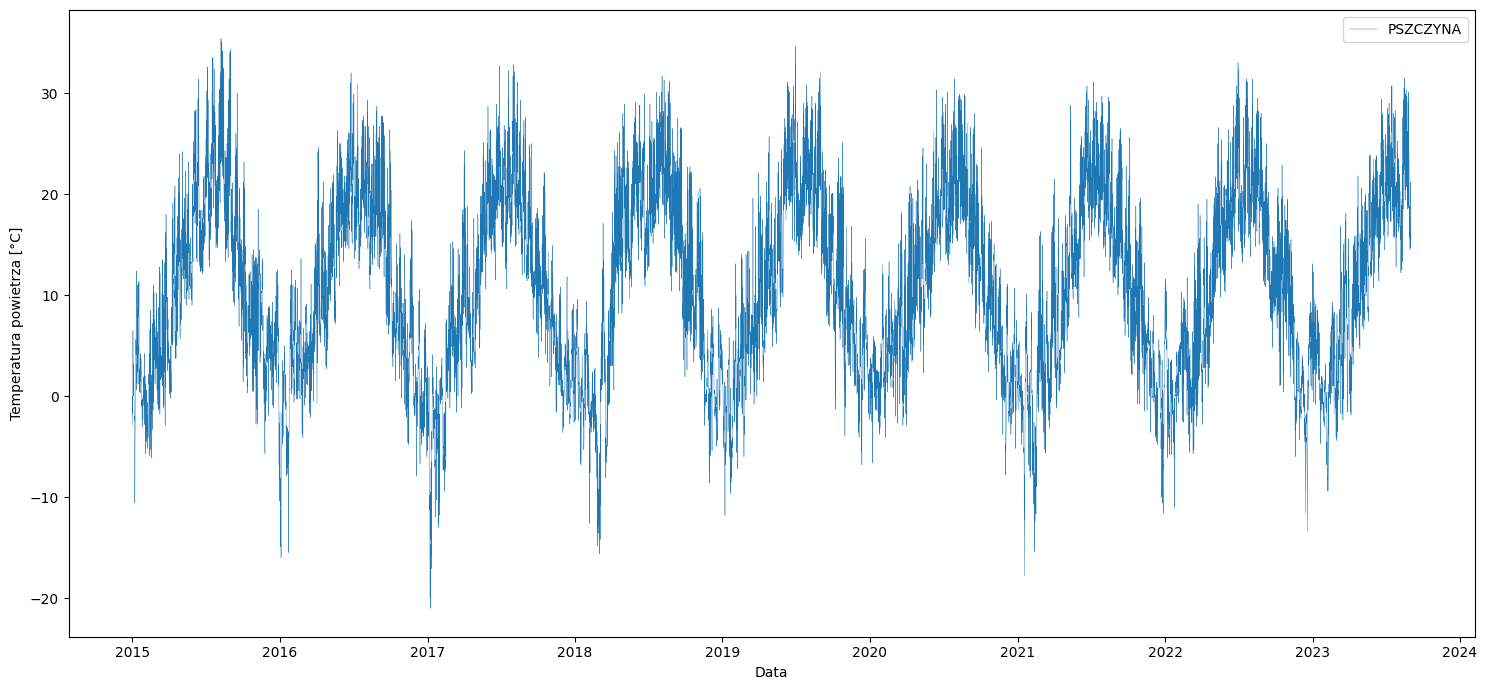

In [11]:
plt.figure(figsize=(15, 7))
subset = df_metro[df_metro['nazwa_stacji'] == 'PSZCZYNA']
plt.plot(subset['datetime'], subset['temperature'], label='PSZCZYNA', linewidth=0.3)
plt.xlabel('Data')
plt.ylabel('Temperatura powietrza [°C]')
plt.legend()
plt.tight_layout()
plt.show()

-------------------------------
# Przetwarzanie danych meteorologicznych
------------------------------------

# Interpolacja temperatury powietrza

In [12]:
def interpolate_station_temperature_akima(station_data):
    station_data.set_index('datetime', inplace=True)
    return round(station_data['temperature'].resample('1H').interpolate(method='akima'), 2)

all_interpolated_data = pd.DataFrame()

for station_name in df_metro['nazwa_stacji'].unique():
    station_specific_data = df_metro[df_metro['nazwa_stacji'] == station_name]
    interpolated = interpolate_station_temperature_akima(station_specific_data.copy())
    interpolated_df = interpolated.reset_index()
    interpolated_df['nazwa_stacji'] = station_name
    all_interpolated_data = pd.concat([all_interpolated_data, interpolated_df])

all_interpolated_data.reset_index(drop=True, inplace=True)

# Wizualizacja intrpolowanych danych w pięciodniowym zakresie dla przykładowej stacji

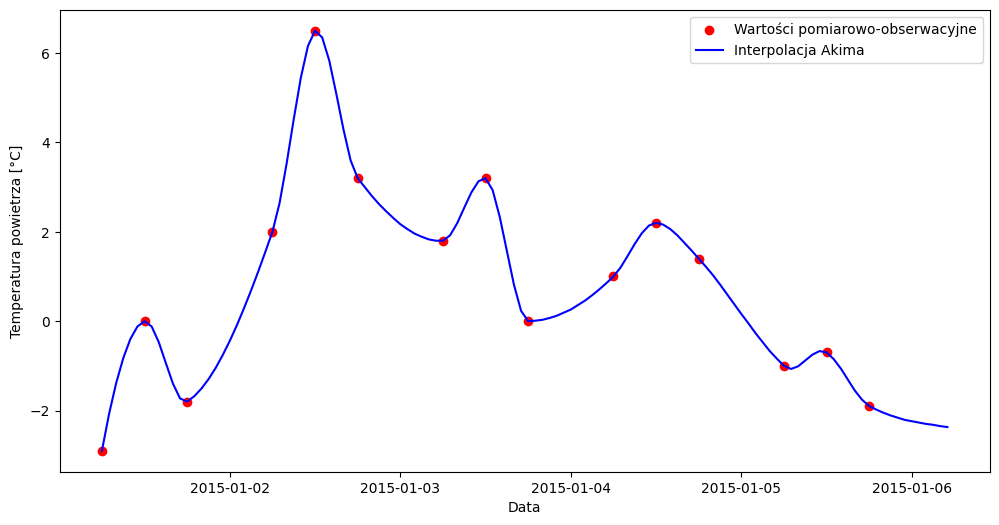

In [13]:
stacja_df = df_metro[df_metro['nazwa_stacji'] == 'PSZCZYNA'].iloc[:15]
stacja_df_interpolated = all_interpolated_data[all_interpolated_data['nazwa_stacji'] == 'PSZCZYNA'].iloc[:120]

plt.figure(figsize=(12, 6))
plt.scatter(stacja_df['datetime'], stacja_df['temperature'], label='Wartości pomiarowo-obserwacyjne', color='red')
plt.plot(stacja_df_interpolated['datetime'], stacja_df_interpolated['temperature'], label='Interpolacja Akima', color='blue')
plt.xlabel('Data')
plt.ylabel('Temperatura powietrza [°C]')
plt.legend()
plt.show()

# Agregacja temperatury powietrza

In [14]:
df_metro = df_metro.sort_values('datetime')
median_temperatures = all_interpolated_data.groupby('datetime')['temperature'].median().reset_index()

# Wizualizacja uzyskanej reprezentatywnej temperatury dla całego kraju

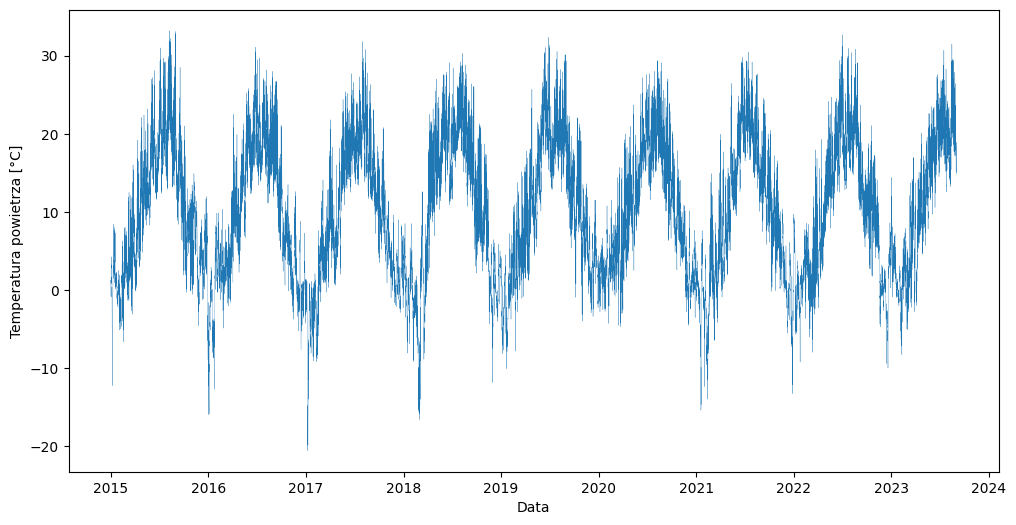

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(median_temperatures['datetime'], median_temperatures['temperature'], linewidth=0.2)
plt.xlabel('Data')
plt.ylabel('Temperatura powietrza [°C]')
plt.show()

---------------------------------------
# Złączenie zestawów danych
---------------------------------------

In [16]:
df = df_load.merge(median_temperatures[['datetime', 'temperature']], left_on='date', right_on='datetime', how='inner')

df = df[df.columns.drop('datetime')]
df_pse = pd.DataFrame()
df_pse['date'] = df['date']
df_pse['forecasted_load'] = df['forecasted_load']
df_pse['electricity_load'] = df['electricity_load']
df_pse['hour'] = df_pse['date'].dt.hour
df = df.drop(['forecasted_load'], axis=1)

# Utworzenie dodatkowych atrybutów

In [17]:
import holidays

df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month

df['day_of_the_week'] = df['date'].dt.day_name()
day_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}
df['day_of_the_week'] = df['day_of_the_week'].map(day_mapping)

pl_holidays = holidays.Poland()
df["holiday"] = df["date"].apply(lambda x: 1 if x in pl_holidays else 0)
df = df.drop(['date'], axis=1)
df['temperature'] = df['temperature'].round(2)

# Przykładowy wycinek w pełni przetworzonego zbioru danych

In [18]:
df.tail()

,electricity_load,temperature,hour,day,month,day_of_the_week,holiday
75916,20557.650,18.49,14,31,8,3,0
75917,20174.113,17.84,15,31,8,3,0
75918,20385.138,16.96,16,31,8,3,0
75919,20411.850,16.06,17,31,8,3,0
75920,20356.238,14.85,18,31,8,3,0


# Zapisane przetworzonego zbioru danych do pliku CSV

In [19]:
df.to_csv('data/preprocessed_data.csv', index=False)

# Zapisanie predykcji PSE do pliku CSV

In [20]:
df_pse.to_csv('data/predictions_pse.csv', index=False)